# Bayesian Change Point Model in Discrete Space

## \*\*\* Utils \*\*\*

In [17]:
%run include/utils.py
%matplotlib inline 

## Graphical Model

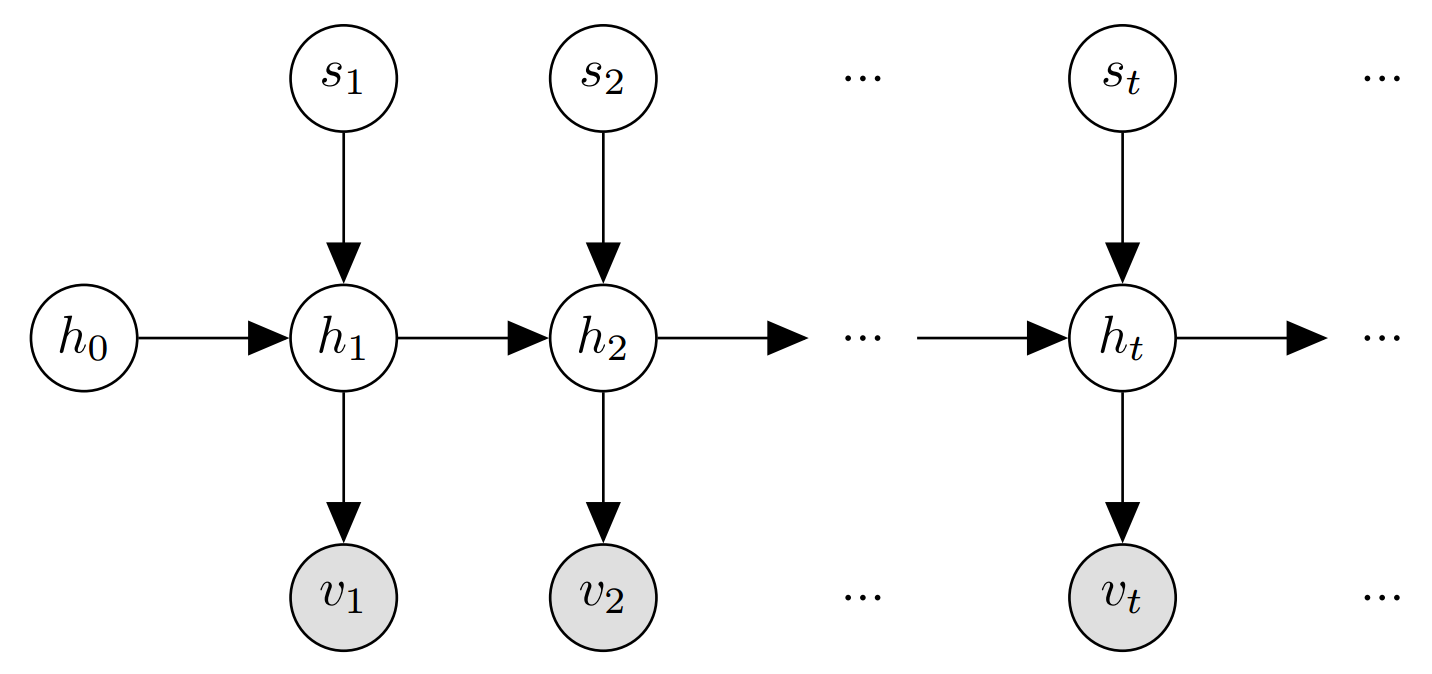

In [2]:
Image(filename='etc/graphical_model3.png', width=500, height=200)

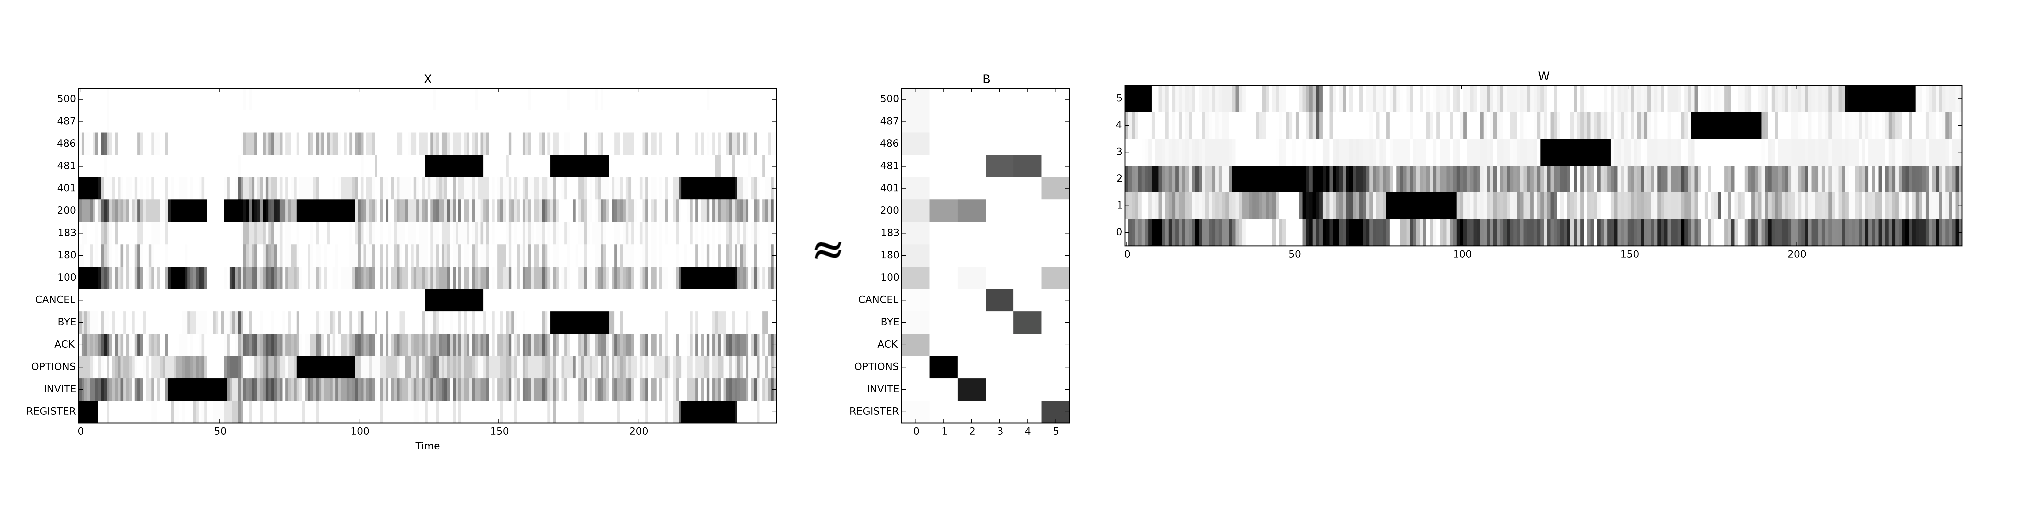

In [3]:
Image(filename='etc/icml_nmf_figure.png')

We combine nonnegative matrix factorization and Bayesian change point model as follows: Given a data set, we first run the NMF algorithm to learn basis vectors, or network traffic templates. As previously discussed, we associate each basis vector with a network state, where the number and characteristics of network states depend on the data set. Our experimental setup produces 6 different network states: normal traffic, OPTIONS, INVITE, CANCEL, BYE and REGISTER attacks. The matrix in the middle of the above figure illustrates a template matrix. Columns of the matrix are in the same order as aforementioned network states.

Current model assumes that at any time $t$, the network is in one of its $K$ latent states. We say that a change occurs if the network state at time $t$ and $t-1$ are not the same. Thus, this time, our BCPM does not track the density/intensity of the traffic generating mechanism but the state of the network.

* $K$: Number of states 
* $M$: Number of distinct observations
* Columns of $B \in \mathcal{R}^{M\times K}$ are the emission probabilities, where $B(i)$ corresponds to $i$'th column of B and is the emission probability of state $i \in \{1 \cdots K\}$
* $c_t \in \{0,1\}$ are switches, where 0 represents no change and 1 represents a change
* $h_t \in \mathcal{R}^K$ are latent variables, our belief on the network state
* $v_t \in \mathcal{R}^M$ are the observation vectors

\begin{align}
h_0  &\sim p(h_0; \pi) \\
s_t  &\sim \mathcal{BE}(s_t; c) \\
h_t | s_t, h_{t-1}  &\sim [s_{t}=0] \delta(h_{t} - h_{t-1}) + [s_{t}=1] p(h_t ; \pi)\\
v_t | h_t  &\sim \prod_i [h_t=i]\mathcal{M}(v_t ; B(i))
\end{align}

## Data Generation

[18 62 65 74 93 98]


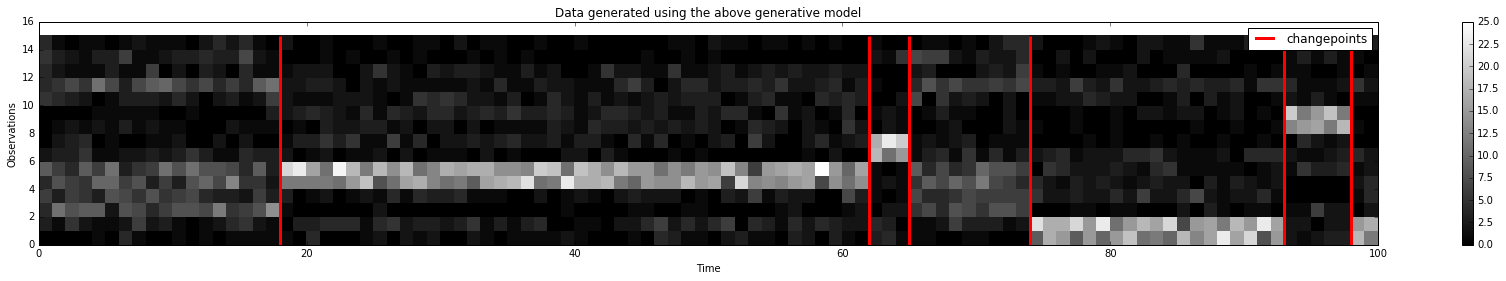

In [8]:
K = 6
M = 15
T = 100

c = 0.05
pi = np.ones(K)
B = np.random.random((M, K)) 
idx = np.arange(int(M/K)*K)
# idx = np.random.permutation(np.arange(int(M/K)*K))
idx = np.reshape(idx,(K,int(M/K)))
for i in range(K-1):
    B[idx[i,:],i] += 5
B = normalize(B)

def gen_data(c_=c, pi_=pi, B_=B, T_=T):
    [M_, K_] = B.shape
    S = np.random.binomial(1, c_, size=T_)
    cps = np.where(S==1)[0]
    H = np.zeros(T_)
    V = np.zeros((M_,T_))
    for t in range(T_):
        if t==0:
            H[t] = randgen(pi_)
        elif S[t]:
            H[t] = randgen(pi_)
            while H[t] == H[t-1]:
                H[t] = randgen(pi_)
        else:
            H[t] = H[t-1]
        V[:,t] = np.random.multinomial(50, B_[:,int(H[t])])
    return cps, S, H, V

cps, S, H, V = gen_data()
plot_hist(V,S,title="Data generated using the above generative model", xlabel="Time",ylabel="Observations")
print(cps)

## Forward Filtering on Synthetic Data

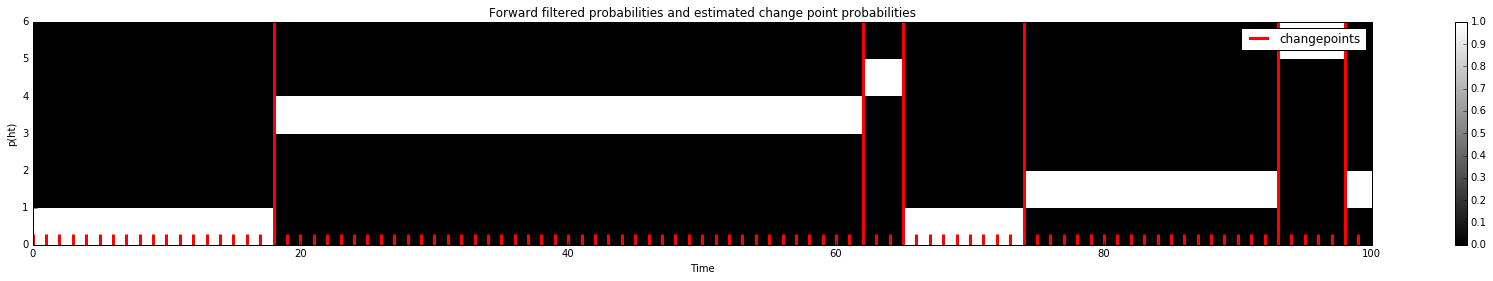

In [9]:
def log_fac(x):
    return np.sum(np.log(1+np.arange(np.sum(x))))

def obs_ll(x, log_pi):
    x = np.array(x)
    t1 = log_fac(np.sum(x))
    t2 = np.sum(np.array([log_fac(n) for n in x]))
    t3 = np.sum(np.array([x[i]*log_pi[i] for i in range(x.shape[0])]))
    return t1-t2+t3

a = np.arange(K)
np.random.shuffle(a)
log_B = np.log(B[:,a])
log_pi = np.log(pi)
log_cpp = np.log(c)
log_no_cpp = np.log(1-c)

# needs logB, loga, cpp
# index-1: [const, distribution on states]
# index-2: particles, last particle represents change
# index-3: time
cpps = np.array([])
means = np.empty((0,K))
msgs = np.zeros((K+1,T+1,T))
for t in range(T):
    # predict
    if t==0:
        msgs[0,0,t] = log_no_cpp
        msgs[1:,0,t] = log_pi
        msgs[0,1,t] = log_cpp
        msgs[1:,1,t] = log_pi
    else:
        msgs[:,:t+1,t] = msgs[:,:t+1,t-1]
        msgs[0,:t+1,t] += log_no_cpp
        msgs[0,t+1,t] = log_sum_exp(msgs[0,:t+1,t-1])[0] + log_cpp
        msgs[1:,t+1,t] = log_pi
    # update
    for p in range(t+2): # eval ll for each particle
        for s in range(K):
            msgs[s+1,p,t] += obs_ll(V[:,t], log_B[:,s])
        msgs[0,p,t] += log_sum_exp(msgs[1:,p,t])
        msgs[1:,p,t] = np.log(normalize_exp(msgs[1:,p,t]))
    tmp = normalize_exp(msgs[0,:t+2,t])
    cpps = np.hstack((cpps,tmp[-1]))
    means = np.vstack(( means, normalize(np.dot(np.exp(msgs[1:,:t+2,t]),tmp)) ))
    # print(str(t) + " " + str(tmp[-1]))

plot_hist(means.T,cpps,title="Forward filtered probabilities and estimated change point probabilities", xlabel="Time",ylabel="p(ht)")

## A New Model: Reset-HMM-LDS (Deneme)

In [ ]:
Image(filename='etc/reset-hmm-lds.png', width=500, height=200)

* $S$: Number of models
* $M$: The length of the observation vector
* $c_t \in \{0,1\}$, where 0 represents no change and 1 represents a change
* $s_t \in \{1,2,...,S\}$

\begin{align}
h_0  &\sim p(h_0) \\
s_0  &\sim p(s_0) \\
s_t  &\sim p(s_t|c_t,s_{t-1}) \\
h_t  &\sim p(h_t|s_t,h_{t-1}) \\
y_t  &\sim p(y_t|h_t)
\end{align}

Change point probability in this model is defined in terms of a change on the Markov chain on $s_t$. In other words,
\begin{align}
p(c_t=1|s_t, s_{t-1}) &= [s_t \neq s_{t-1}] 
\end{align}

Hidden states $h_t$ in this model are conditioned on the model, $s_t$ (In our previous model, it was conditioned only on the switch). Thus, we do not necessarily propagate particles as they are, new rules that may modify particles depending upon the model at current time could be considered. For the time being, we just ignore this dependency:
\begin{align}
p(h_t=1|h_{t-1},s_t,c_t) &= [c_t=0]\delta(h_t-h_{t-1}) + [c_t=1]p(h_t|s_t)
\end{align}
In each time step, $S$ additional particles are created, in addition to those that are propagated. The normalizing constant of each propagated particle is updated by the log of no change probability. That of each newly created particle is updated by the log of change probability plus the log of new model's probability.

## Generative Model

The model is in discrete space. This is to say, latent variables $\pi_i$ are simply $N$ dimensional probability vectors over hidden variables and the transition between latent variables are governed by a $N\times N$ matrix $A$, if $N$ is the number of hidden states. In our setup, observation model is also discrete and governed by a $M\times N$ matrix $M$, where there exist $C$ different observations. Switches are at the highest level in the hierarchy. In our simple example, we assume that switches are binary variables.

\begin{align}
x_0  &\sim p(x_0; \pi) \\
r_t  &\sim \mathcal{BE}(r_t; c) \\
x_t | r_t, x_{t-1}  &\sim [r_{t}=0] \delta(x_{t} - x_{t-1}) + [r_{t}=1] p(x_t| \pi)\\
y_t | x_t  &\sim p(y_t | x_t)
\end{align}

We again have mixture components, in which we store the potential on $x_t$ and the normalization constant in the log domain. 

In [ ]:
class MixtureComponent:
    def __init__(self,log_x_,log_c_):
        self.log_x = log_x_
        self.log_c = log_c_
    def copy(self):
        return MixtureComponent(self.log_x.copy(), self.log_c)

In [15]:
# Reset-HMM-LDS at Barber's book

# c1   c2   c3   c4
# |    |    |    |
# s1-->s2-->s3-->s4
# |    |    |    |
# h1-->h2-->h3-->h4
# |    |    |    |
# v1   v2   v3   v4 

class DBCPM:
    def set_c(self, c_):
        self.c = c_
        self.log_c = np.log(self.c)
    def set_pi(self, pi_):
        self.pi = normalize(pi_)
        self.log_pi = np.log(self.pi)
    def set_A(self, A_):
        self.A = normalize(A_)
        self.log_A = np.log(self.A)
    def set_B(self, B_):
        self.B = normalize(B_)
        self.log_B = np.log(self.B)
        
    def __init__(self, c_, pi_, A_, B_):
        self.set_c(c_)      # change point probability
        self.set_pi(pi_)    # reset probabilities
        self.set_A(A_)      # colums store reset params
        self.set_B(B_)      # observation matrix
        self.M = self.B.shape[0]    # number of observations
        self.S = self.B.shape[1]    # number of models
          
    @staticmethod
    def init(S_=5, M_=12, c_=0.1):
        pi_ = np.ones(S_)               # flat prior
        # pi_[-1] = 100
        A_ = np.eye(S_) + 0.1           # each model favors its index
        A_[:,-1] = np.ones(S_)
        B_ = np.random.random((M_, S_)) # random observation model
        # tmp = np.random.permutation(np.arange(int(M_/S_)*S_))
        tmp = np.arange(int(M_/S_)*S_)
        tmp = np.reshape(tmp,(S_,int(M_/S_)))
        for i in range(S_):
            B_[tmp[i,:],i] += 5
        dbcpm = DBCPM(c_, pi_, A_, B_)
        return dbcpm
        
    def gen_data(self, T=50):
        C = np.random.binomial(1,self.c,size=T)
        cps = np.where(C==1)[0]
        S = np.zeros(T)
        H = np.zeros((self.S,T))
        V = np.zeros((self.M,T))
        for t in range(T):
            if t==0:
                C[t] = 0
                S[t] = randgen(self.pi)
                H[:, t] = self.A[:, int(S[t])] 
            elif C[t]:
                S[t] = randgen(self.pi)
                while S[t] == S[t-1]:
                    S[t] = randgen(self.pi)
                H[:, t] = self.A[:, int(S[t])] 
            else:
                S[t] = S[t-1]
                H[:,t] = H[:,t-1]
            V[:,t] = np.random.multinomial(50,np.dot(self.B, int(H[:,t])))
        return cps, C, S, H, V

In [16]:
S = 3
M = 6
T = 100
dbcpm = DBCPM.init(S, M)
cps, Ct, St, Ht, Vt = dbcpm.gen_data(T)

def plot_hist(data,xlines,title="",xlabel="",ylabel="",label_='changepoints'):
    (K,T) = data.shape
    fig = plt.figure(figsize=(30,4))
    ax = fig.gca()
    y,x = np.mgrid[slice(0, M+1, 1),slice(0,T+1,1)]
    im = ax.pcolormesh(x, y, data, cmap=cm.gray)
    fig.colorbar(im)
    ax.hold(True)
    plt1 = ax.vlines(np.arange(0,T), 0, xlines*M, colors='r', linestyles='-',label=label_,linewidth='3')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(handles=[plt1])
    fig.canvas.draw()
    
plot_hist(Vt,Ct,title="Data generated using the above generative model", xlabel="Time",ylabel="Data Vectors")
print(cps)
# print(dbcpm.B)

TypeError: only length-1 arrays can be converted to Python scalars

In [ ]:
def log_fac(x):
    return np.sum(np.log(1+np.arange(np.sum(x))))

def obs_ll(x, pi):
    x = np.array(x)
    t1 = log_fac(np.sum(x))
    t2 = np.sum(np.array([log_fac(n) for n in x]))
    t3 = np.sum(np.array([x[i]*np.log(pi[i]) for i in range(x.shape[0])]))
    return t1-t2+t3

# S: number of basis = models
# M: length of an observation vector
# T: number of observation vector
B = np.random.random((M, S)) # random observation model
tmp = np.arange(int(M/S)*S)
tmp = np.reshape(tmp,(S,int(M/S)))
for i in range(S):
    B[tmp[i,:],i] += 10
    
B = normalize(B)
a = normalize(np.ones(S))
cpp = 1e-5

log_B = np.log(B)
log_a = np.log(a)
log_cpp = np.log(cpp)
log_no_cpp = np.log(1-cpp)

# needs logB, loga, cpp
# index-1: [const, distribution on states]
# index-2: particles, last particle represents change
# index-3: time
msgs = np.zeros((S+1,T+1,T))
for t in range(T):
    # predict
    if t==0:
        msgs[0,0,t] = log_no_cpp
        msgs[1:,0,t] = log_a
        msgs[0,1,t] = log_cpp
        msgs[1:,1,t] = log_a
    else:
        msgs[:,:t+1,t] = msgs[:,:t+1,t-1]
        msgs[0,:t+1,t] += log_no_cpp
        msgs[0,t+1,t] = log_sum_exp(msgs[0,:t+1,t-1])[0] + log_cpp
        msgs[1:,t+1,t] = log_a
    # update
    for p in range(t+2): # eval ll for each particle
        for s in range(S):
            msgs[s+1,p,t] += obs_ll(Vt[:,t],B[:,s])
        msgs[0,p,t] += log_sum_exp(msgs[1:,p,t])
        msgs[1:,p,t] = np.log(normalize_exp(msgs[1:,p,t]))
    print(str(t) + " " + str(normalize_exp(msgs[0,:t+2,t])[-1]))

In [ ]:
def obs_ll(x, pi):
    x = np.array(x,dtype=np.int16)
    t1 = np.sum(np.log(1+np.arange(np.sum(x))))
    t2 = np.sum(np.log(np.array([np.math.factorial(i) for i in x])))
    t3 = np.sum(np.array([x[i]*np.log(pi[i]) for i in range(x.shape[0])]))
    return t1-t2+t3

def log_fac(x):
    return np.sum(np.log(1+np.arange(np.sum(x))))

print(np.exp(log_fac(5)))

x = np.array([1,4,5])
pi1 = np.array([0.1,0.4,0.5])
pi2 = np.array([0.3,0.4,0.3])
piAvg = normalize(pi1+pi2)

t1 = obs_ll(x,pi1)
print(t1)

In [ ]:
x = np.array(np.log([0.01,0.09]))
lhood = np.exp(log_sum_exp(x))
xn = normalize_exp(x)
print(lhood)
print(xn)